Übung 3.2

In [42]:
from pyomo.environ import *
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


T = 24
timesteps = np.arange(T)

c_CO2 = 80 # EUR/tCO2

# Marginal costs der thermischen Kraftwerke berechnen
# Achtung: entspricht nicht allen Werten in der Angabe! 
thermalPlant = ['Kohle', 'GuD', 'Gasturbine']
power = {'Kohle': 600,
         'GuD': 400,
         'Gasturbine': 300} # MW
efficiency = {'Kohle': 0.41,
         'GuD': 0.58,
         'Gasturbine': 0.4} 
fuel_price = {'Kohle': 10,
         'GuD': 30,
         'Gasturbine': 30} # EUR/MWhprim
emission_factor = {'Kohle': 0.35,
         'GuD': 0.2,
         'Gasturbine': 0.2} # tCO2/MWhprim
MC = {} # marginal costs in EUR/MWh
emissions = {} # emissions in tCO2/MWh
for n in thermalPlant:
    MC[n] = (fuel_price[n] + emission_factor[n] * c_CO2) / efficiency[n]
    emissions[n] = emission_factor[n] / efficiency[n]
    
# Daten laden
df = pd.read_excel('Last_PV_Wind.xlsx')
wind = df['Wind 300 MW']
PV = df['PV 200 MW Sommer']
load = df['Last Sommer [MW]']-df['Wind 300 MW']-df['PV 200 MW Sommer'] # hier nach Gruppennummer Sommer/Winter eingeben
#print(load)
# Pyomo Modell aufstellen

model = ConcreteModel()

model.x = Var(thermalPlant, timesteps, within = NonNegativeReals)

# Zielfunktion angeben!
model.obj = Objective(
    expr = sum(model.x[n,t] * MC[n] for n in thermalPlant for t in timesteps), 
    sense= minimize)

def power_constraint_rule(model, n, t):    
   return model.x[n,t] <= power[n]
model.power_con = Constraint(thermalPlant, 
                             timesteps, 
                             rule = power_constraint_rule)

def load_constraint_rule(model, t):    
   return sum(model.x[n,t] for n in thermalPlant) == load.loc[t]
model.load_con = Constraint(timesteps, 
                            rule = load_constraint_rule)
###Schattenvariable für Punkt c)
model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT_EXPORT)

opt = SolverFactory('gurobi')
opt_success = opt.solve(model)

model.display()

# get values of optimization variables
PowerThermal = pd.DataFrame(index = timesteps, columns = thermalPlant)
guDPower = np.empty(T, dtype=float)
gasPower = np.empty(T, dtype=float)
kohlePower = np.empty(T, dtype=float)
for t in timesteps:
    for n in thermalPlant:
        PowerThermal.loc[t, n] = model.x[n,t].value
        guDPower[t] = PowerThermal.loc[t, 'GuD']
        gasPower[t] = PowerThermal.loc[t, 'Gasturbine']
        kohlePower[t] = PowerThermal.loc[t, 'Kohle']


print()
totalMinCost = model.obj()
print("Gesamtkosten der Stromversorgung:", totalMinCost, "EUR" )
totalEmissions = sum(model.x[n,t].value * emissions[n] for n in thermalPlant for t in timesteps)
print("Gesamte CO2 Emissionen", totalEmissions, "tCO2" )




Model unknown

  Variables:
    x : Size=72, Index={Kohle, GuD, Gasturbine}*{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
        Key                : Lower : Value              : Upper : Fixed : Stale : Domain
         ('Gasturbine', 0) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 1) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 2) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 3) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 4) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 5) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 6) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 7) :     0 :                0.0

b) Grafische Darstellung

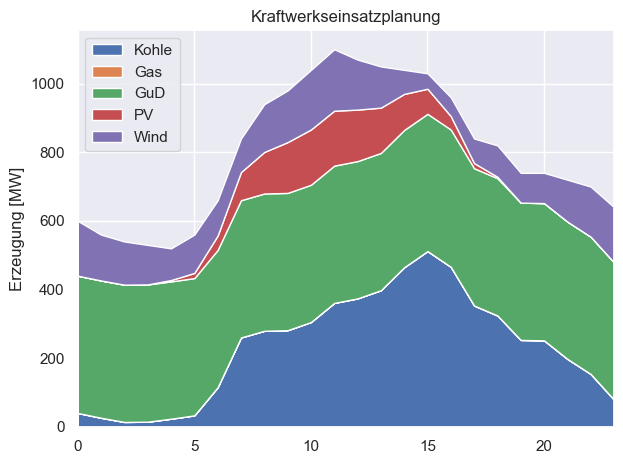

In [43]:
# plot

sns.set()
powerplants={'Kohle', 'Gas', 'GuD', 'PV', 'Wind'}
fig, ax = plt.subplots()
ax.stackplot(timesteps, 
             #PowerThermal.to_numpy(dtype = float).transpose(), wind, PV, 
             kohlePower, gasPower, guDPower,  PV, wind,
             labels=powerplants)
ax.set_title('Kraftwerkseinsatzplanung')
ax.legend(loc='upper left')
ax.set_ylabel('Erzeugung [MW]')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()

c) Nun sollen die stündlichen Strompreise berechnet werden. Die Berechnung wurde mithilfe der Schattenvariable durchgeführt und mithilfe der kurzfristigen Grenzkosten verifiziert.

In [44]:
print("Wert der Schattenvariable [EUR/MWh]:")
for t in timesteps:
    print("Stunde", t+1, ":", model.dual[model.load_con[t]])

Wert der Schattenvariable [EUR/MWh]:
Stunde 1 : 92.6829268292683
Stunde 2 : 92.6829268292683
Stunde 3 : 92.6829268292683
Stunde 4 : 92.6829268292683
Stunde 5 : 92.6829268292683
Stunde 6 : 92.6829268292683
Stunde 7 : 92.6829268292683
Stunde 8 : 92.6829268292683
Stunde 9 : 92.6829268292683
Stunde 10 : 92.6829268292683
Stunde 11 : 92.6829268292683
Stunde 12 : 92.6829268292683
Stunde 13 : 92.6829268292683
Stunde 14 : 92.6829268292683
Stunde 15 : 92.6829268292683
Stunde 16 : 92.6829268292683
Stunde 17 : 92.6829268292683
Stunde 18 : 92.6829268292683
Stunde 19 : 92.6829268292683
Stunde 20 : 92.6829268292683
Stunde 21 : 92.6829268292683
Stunde 22 : 92.6829268292683
Stunde 23 : 92.6829268292683
Stunde 24 : 92.6829268292683


In [45]:
print("Grenzkosten der Kraftwerke:")
print(MC)
print()
print("Strompreis [EUR/MWh]:")
for t in timesteps:
    maxMC=0
    for n in thermalPlant:
        if model.x[n,t].value > 0:
            if MC[n] > maxMC:
                maxMC=MC[n]
    print("Stunde", t+1, ":" ,maxMC)

Grenzkosten der Kraftwerke:
{'Kohle': 92.6829268292683, 'GuD': 79.3103448275862, 'Gasturbine': 115.0}

Strompreis [EUR/MWh]:
Stunde 1 : 92.6829268292683
Stunde 2 : 92.6829268292683
Stunde 3 : 92.6829268292683
Stunde 4 : 92.6829268292683
Stunde 5 : 92.6829268292683
Stunde 6 : 92.6829268292683
Stunde 7 : 92.6829268292683
Stunde 8 : 92.6829268292683
Stunde 9 : 92.6829268292683
Stunde 10 : 92.6829268292683
Stunde 11 : 92.6829268292683
Stunde 12 : 92.6829268292683
Stunde 13 : 92.6829268292683
Stunde 14 : 92.6829268292683
Stunde 15 : 92.6829268292683
Stunde 16 : 92.6829268292683
Stunde 17 : 92.6829268292683
Stunde 18 : 92.6829268292683
Stunde 19 : 92.6829268292683
Stunde 20 : 92.6829268292683
Stunde 21 : 92.6829268292683
Stunde 22 : 92.6829268292683
Stunde 23 : 92.6829268292683
Stunde 24 : 92.6829268292683
